In [13]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import *
from sklearn.ensemble import *
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.metrics import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

sns.set(font="simhei", style="white", font_scale=1.6)
import matplotlib

matplotlib.rcParams['axes.unicode_minus'] = False  # 解决坐标轴的负号显示问题


def chinese2english(df):
    columnsDict = {
        'Length': '长度',
        'Geographic Region': '地理区域',
        'Country': '国家',
        'Listing Price': '售价',
        'Year': '年份',
        'Make Variant': '名称',
        'LWL': '水线长度',
        'Beam': '宽度',
        'Draft': '吃水',
        'Displacement': '排水',
        'Sail Area': '帆面积',
        'AVG Cargo Thro.': '平均货物吞吐量',
        'GDP': 'GDP',
        'GDP per capita': '人均GDP',
        'Average proportion of total logistics cost to GDP': '物流总成本占GDP的平均比例',
        'Hull Type': '类型',
    }
    print({v: k for k, v in columnsDict.items()})
    return df.rename(columns={v: k for k, v in columnsDict.items()})


def getxy():
    exceptCol = [
        '地理区域',
        '平均货物吞吐量',
        '人均GDP',
        '物流总成本占GDP的平均比例',
    ]

    df = pd.read_excel(r'../数据预处理/xlsx/合并修正缩放后总数据.xlsx', sheet_name='未编码汇总')
    df.drop(columns=exceptCol, inplace=True, axis=1)
    X = df
    y = df.pop('售价')
    return X, y, df

In [14]:
## 读取GDP的经济数据（这里也可以使用提供的人均GDP进行分析，分析方法相似）
gdpDf = pd.read_csv("世界银行GDP数据.csv")
## Florida使用的是每个的数据，由于Florida是美国的一个州，所以将其除以50
gdpDf.iloc[5, 5:] = gdpDf.iloc[5, 5:] / 50
gdpDf


,CountryName,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Greece,希腊,GRC,GDP（现价美元）,NY.GDP.MKTP.CD,4.335186e+09,4.961400e+09,5.213048e+09,5.895278e+09,6.669673e+09,...,2.420000e+11,2.390000e+11,2.350000e+11,1.960000e+11,1.930000e+11,2.000000e+11,2.120000e+11,2.050000e+11,1.890000e+11,2.150000e+11
1,Croatia,克罗地亚,HRV,GDP（现价美元）,NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,...,5.736936e+10,5.903207e+10,5.842398e+10,5.024278e+10,5.239749e+10,5.632384e+10,6.231684e+10,6.232798e+10,5.747201e+10,6.895508e+10
2,France,法国,FRA,GDP（现价美元）,NY.GDP.MKTP.CD,6.222548e+10,6.746164e+10,7.560753e+10,8.475920e+10,9.400785e+10,...,2.680000e+12,2.810000e+12,2.860000e+12,2.440000e+12,2.470000e+12,2.600000e+12,2.790000e+12,2.730000e+12,2.640000e+12,2.960000e+12
3,Italy,意大利,ITA,GDP（现价美元）,NY.GDP.MKTP.CD,4.038529e+10,4.484276e+10,5.038389e+10,5.771074e+10,6.317542e+10,...,2.090000e+12,2.140000e+12,2.160000e+12,1.840000e+12,1.880000e+12,1.960000e+12,2.090000e+12,2.010000e+12,1.900000e+12,2.110000e+12
4,Spain,西班牙,ESP,GDP（现价美元）,NY.GDP.MKTP.CD,1.207213e+10,1.383430e+10,1.613855e+10,1.907491e+10,2.134384e+10,...,1.320000e+12,1.360000e+12,1.370000e+12,1.200000e+12,1.230000e+12,1.310000e+12,1.420000e+12,1.390000e+12,1.280000e+12,1.430000e+12
5,Florida,美国,USA,GDP（现价美元）,NY.GDP.MKTP.CD,1.086000e+10,1.126000e+10,1.210000e+10,1.278000e+10,1.372000e+10,...,3.260000e+11,3.360000e+11,3.520000e+11,3.640000e+11,3.740000e+11,3.900000e+11,4.100000e+11,4.280000e+11,4.220000e+11,4.660000e+11
6,Hongkong,中国香港特别行政区,HKG,GDP（现价美元）,NY.GDP.MKTP.CD,1.320797e+09,1.383682e+09,1.612346e+09,1.935298e+09,2.206466e+09,...,2.630000e+11,2.760000e+11,2.910000e+11,3.090000e+11,3.210000e+11,3.410000e+11,3.620000e+11,3.630000e+11,3.450000e+11,3.690000e+11


In [15]:
## 将宽数据转化为长数据
value_vars = gdpDf.columns[5:]
id_vars = gdpDf.columns[0:1]
gdpdf2 = gdpDf.melt(id_vars=id_vars, value_vars=value_vars,
                    var_name="Year", value_name="GDP")
gdpdf2["Year"] = np.int64(gdpdf2.Year.values)
gdpdf2.columns = ["CountryRegionState2", "Year", "GDP"]
gdpdf2


,CountryRegionState2,Year,GDP
0,Greece,1960,4.335186e+09
1,Croatia,1960,NaN
2,France,1960,6.222548e+10
3,Italy,1960,4.038529e+10
4,Spain,1960,1.207213e+10
...,...,...,...
429,France,2021,2.960000e+12
430,Italy,2021,2.110000e+12
431,Spain,2021,1.430000e+12
432,Florida,2021,4.660000e+11


            Greece   Croatia    France     Italy     Spain   Florida  Hongkong
Greece    1.000000  0.799175  0.757302  0.875609  0.848596  0.365741  0.179599
Croatia   0.799175  1.000000  0.988665  0.978832  0.992121  0.837482  0.727113
France    0.757302  0.988665  1.000000  0.973719  0.980457  0.843984  0.750781
Italy     0.875609  0.978832  0.973719  1.000000  0.991291  0.736385  0.607518
Spain     0.848596  0.992121  0.980457  0.991291  1.000000  0.791697  0.665941
Florida   0.365741  0.837482  0.843984  0.736385  0.791697  1.000000  0.963087
Hongkong  0.179599  0.727113  0.750781  0.607518  0.665941  0.963087  1.000000


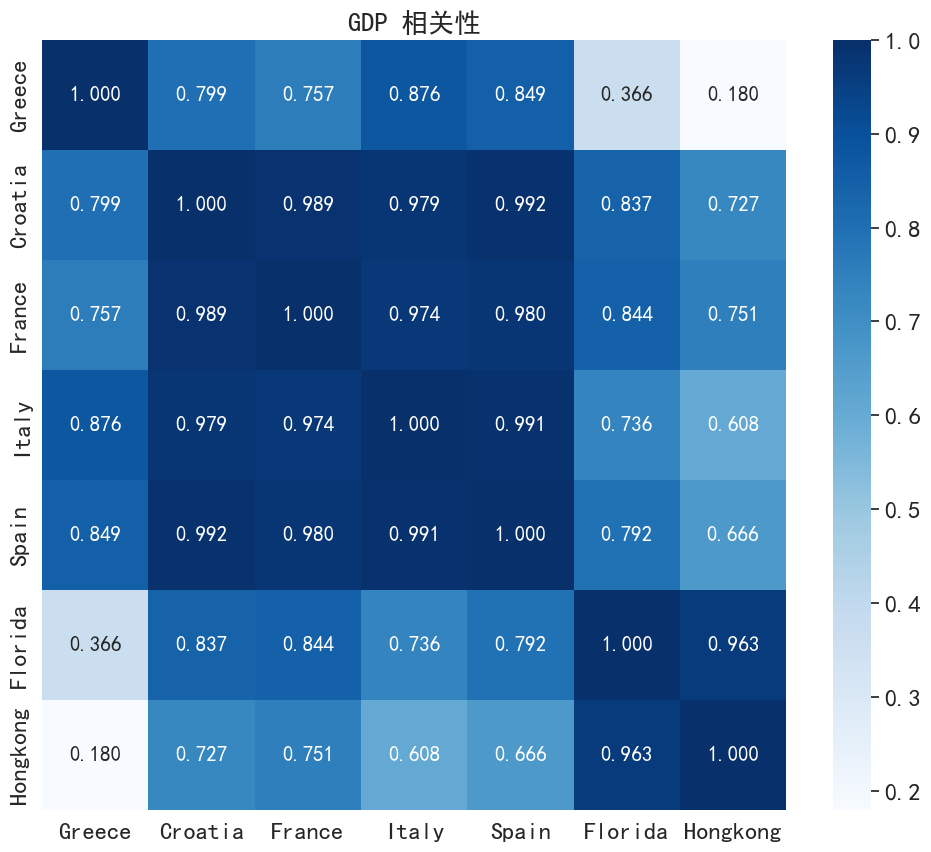

In [24]:
## 使用1995后的数据进行相似性分析（此时有一个地区的数据不在有缺失值）
cortab = np.corrcoef(gdpDf.iloc[:, 40:].values)
cortabdf = pd.DataFrame(data=cortab, columns=gdpDf.CountryName.values,
                        index=gdpDf.CountryName.values)
print(cortabdf)

plt.figure(figsize=(12, 10))
sns.heatmap(cortabdf, cmap="Blues", annot=True, fmt=".3f",
            annot_kws={"fontsize": 15})
plt.title("GDP 相关性")
plt.show()

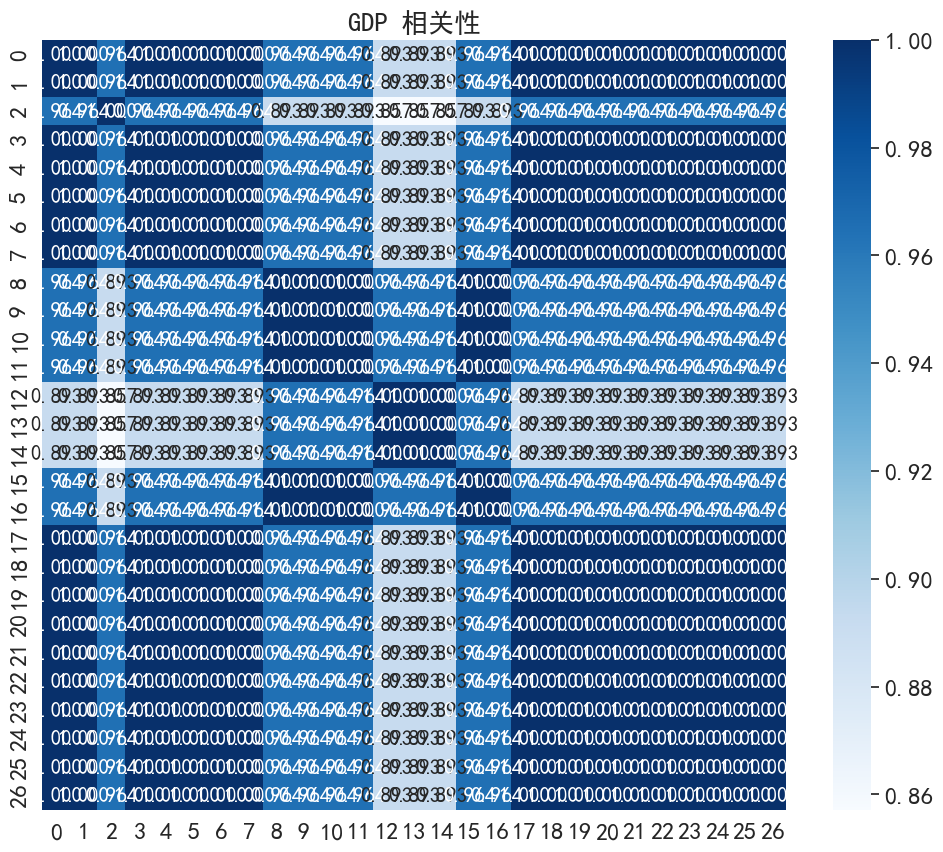

In [28]:
from scipy.stats import spearmanr
corr_matrix, p_matrix = spearmanr(gdpDf.iloc[:, 40:])

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap="Blues", annot=True, fmt=".3f",
            annot_kws={"fontsize": 15})
plt.title("GDP 相关性")
plt.show()

<Axes: >

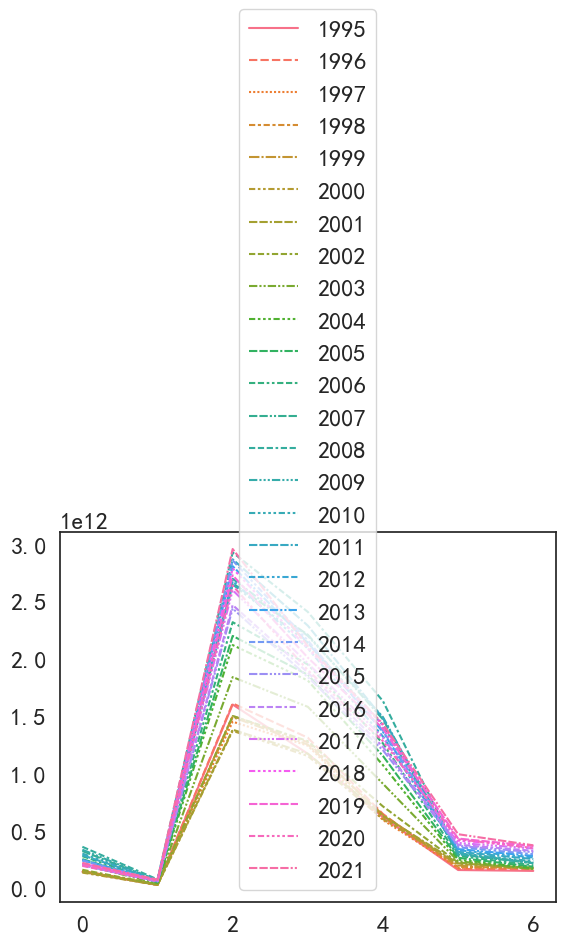

In [31]:

sns.lineplot(gdpDf.iloc[:, 40:])